# Show results

In [9]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp


import utils.torch_resistance_metrics as ermet
import torch
import seaborn as sns
import pandas as pd

In [10]:
N_LOADED_LINKS = 5000
N_LINKS = 5000
DATASET = ['facebook','UNC28', 'google'][2]
PATH_FIGURES = osp.join('.', 'results', 'figures')
#MODEL = args.model
#STRATEGY = args.strategy
#DEVICE = args.device

FILTER = True
SELECTED_METHODS =  ['deepwalk_strong', 'random_weak','cosine_strong', 'SDRF_weak', 'FOSR_weak', 'ERP_weak']
PATH_FIGURES

'.\\results\\figures'

In [11]:
#List all folders under the folder 'results' with the name of the dataset and the number of links
folders = [f for f in os.listdir('results') if osp.isdir(osp.join('results', f)) and f.startswith(DATASET+'_') and str(N_LOADED_LINKS)+'lnks' in f]
folders

['google_cosine_strong_5000lnks_13_12_23__05_05_36',
 'google_cosine_weak_5000lnks_13_12_23__06_17_25',
 'google_deepwalk_strong_5000lnks_13_12_23__08_47_24',
 'google_deepwalk_strong_5000lnks_13_12_23__11_54_58',
 'google_deepwalk_strong_5000lnks_13_12_23__15_05_51',
 'google_deepwalk_weak_5000lnks_13_12_23__18_33_36',
 'google_deepwalk_weak_5000lnks_13_12_23__21_48_14',
 'google_deepwalk_weak_5000lnks_14_12_23__00_55_59',
 'google_ERP_strong_5000lnks_13_12_23__03_52_30',
 'google_ERP_weak_5000lnks_13_12_23__04_28_42',
 'google_FOSR_weak_5000lnks_11_04_24__14_28_35',
 'google_random_weak_5000lnks_13_12_23__07_27_53',
 'google_random_weak_5000lnks_13_12_23__07_54_23',
 'google_random_weak_5000lnks_13_12_23__08_20_51',
 'google_SDRF_weak_5000lnks_10_04_24__13_12_18']

In [12]:
#Get model and strategy from folder name
model = folders[0].split('_')[1]
strategy = folders[0].split('_')[2]

model_key = model+'_'+strategy

R= np.load(open(osp.join('results', folders[0], 'R.npy'), 'rb'))

N_NODES = R.shape[0]
N_NODES

3508

In [13]:
group_results_dict = {}
for fold in folders:
    # get model and strategy from folder name
    model = fold.split('_')[1]
    strategy = fold.split('_')[2]

    model_key = model+'_'+strategy

    loaded_res = pickle.load(open(osp.join('results', fold, 'results_dict.pkl'), 'rb'))
    if model_key not in group_results_dict:
        #group_results_dict[model+'_'+strategy] = loaded_res
        d = dict()
        for k,v in loaded_res.items():
            d[k]=dict()
            for q, v2 in v.items():
                d[k][q]=v2[:N_LINKS+1]
        group_results_dict[model+'_'+strategy] = d
        
    else:
        # stack results if different runs
        for group in group_results_dict[model_key]:
            for metric in group_results_dict[model_key][group]:
                group_results_dict[model_key][group][metric] = np.vstack((group_results_dict[model_key][group][metric], loaded_res[group][metric][:N_LINKS+1]))

In [14]:
if FILTER:
    dd = {k:group_results_dict[k] for k in SELECTED_METHODS}
group_results_dict = dd

In [15]:
# get mean and std for each group and metric - Not for ERP, but random and others yes
group_mean_results_dict = {}
group_std_results_dict = {}

for model_key in group_results_dict:
    group_mean_results_dict[model_key] = {}
    group_std_results_dict[model_key] = {}
    for group in group_results_dict[model_key]:
        group_mean_results_dict[model_key][group] = {}
        group_std_results_dict[model_key][group] = {}
        for metric in group_results_dict[model_key][group]:
            runs = np.array(group_results_dict[model_key][group][metric]).ndim
            if runs == 1:
                group_mean_results_dict[model_key][group][metric] = np.array(group_results_dict[model_key][group][metric])
                group_std_results_dict[model_key][group][metric] = np.zeros(len(group_results_dict[model_key][group][metric]))
            else:
                group_mean_results_dict[model_key][group][metric] = np.mean(group_results_dict[model_key][group][metric], axis=0)
                group_std_results_dict[model_key][group][metric] = np.std(group_results_dict[model_key][group][metric], axis=0)

In [16]:
metrics = list(group_mean_results_dict['random_weak'][0].keys())
metrics

['total_er', 'diameter', 'avg_diam', 'avg_betw', 'std_betw']

In [17]:
#set matplotlib style
# set font to times new roman - like paper
plt.rcParams["font.family"] = "Times New Roman"
# set tick font size
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
# set title and label font size
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
# set legend font size
plt.rcParams['legend.fontsize'] = 12
# set figure color
plt.rcParams['axes.facecolor'] = 'ghostwhite'


In [18]:
from matplotlib.colors import ListedColormap
tab10 = plt.get_cmap('tab10')

# Darken the colors by reducing brightness
dark_factor = .7  # Adjust this factor to control darkness
darkened_colors = [(dark_factor * r, dark_factor * g, dark_factor * b) for r, g, b in tab10.colors]

# Create a new colormap with darkened colors
cmap = ListedColormap(darkened_colors, name='dark_tab10')

In [26]:
rename_methods = {
    'original': '$G$',
    'cosine_strong': 'Cos',
    'cosine_weak': 'S-Cos',
    'deepwalk_weak': 'S-DW',
    'deepwalk_strong': 'DW',
    'random_weak': 'Rand',
    'ERP_weak': 'ERG',
    'ERP_strong': 'S-ERG',
    'SDRF_weak': 'SDRF',
    'FOSR_weak': 'FOSR'
}

color_methods = {
    'original': 'black',
    'cosine_strong': cmap(0),
    'cosine_weak': cmap(4),
    'deepwalk_weak': cmap(5),
    'deepwalk_strong': cmap(3),
    'random_weak': cmap(1),
    'ERP_weak': cmap(2),
    'ERP_strong': cmap(6),
    'SDRF_weak': cmap(7),
    'FOSR_weak': cmap(8)
}


rename_metrics = {
    'Ruv':'$R_{uv}$',
    'total_er': '$R_{tot}$',
    'diameter': 'TOT$\mathcal{R}_{diam}$',
    'avg_diam': '$\mathcal{R}_{diam}$',
    'avg_betw':'$\mathsf{B_R}$',
    'betw':'$\mathsf{B_R}$',
    'std_betw':'Var$(\mathsf{B_R})$'
}

if DATASET == 'google':
    rename_groups = {
        1:'Male',
        0:'Female',
    }
else:
        rename_groups = {
        1:'Female',
        0:'Male'
    }

## Metric Evolution for one group with different models
* 1 plot for each metric
* One line for each metric evolution with different models
* Only one group

In [ ]:
def plt_evolution_group(GROUP, metric, save=False, slegend=True, lims=None):
    colors = cmap(np.linspace(0, 1, len(group_mean_results_dict)))

    if slegend:
        fig, ax = plt.subplots(figsize=(5, 2.7))
    else:
        fig, ax = plt.subplots(figsize=(3.9, 2.7))
    for i, model_key in enumerate(group_mean_results_dict):
        if i==0:
            plt.scatter(0, group_mean_results_dict[model_key][GROUP][metric][0],
                        color='black', label = rename_methods['original'],
                        zorder=10, s=50)
            xlimit = len(group_mean_results_dict[model_key][GROUP][metric])
        mean_res = group_mean_results_dict[model_key][GROUP][metric]
        std_res = group_std_results_dict[model_key][GROUP][metric]
        ax.plot(mean_res, color=color_methods[model_key], linewidth=3, alpha=0.7, label=rename_methods[model_key])
        #ax.fill_between(np.arange(len(mean_res)), mean_res-std_res, mean_res+std_res, color=colors[i], alpha=0.2)



    ax.set_ylabel(rename_metrics[metric]+'('+rename_groups[GROUP]+')')
    ax.set_xlabel("$|\mathcal{E}'\:\\backslash\:\mathcal{E}|$")
    #ax.set_ylabel(rename_metrics[metric])

    
    # place legend outside
    if slegend:
        """ax.legend(bbox_to_anchor=(1.0, .5), loc='center left',
                borderaxespad=0., fancybox=True, shadow=True,
                facecolor='white', framealpha=1,frameon=False
                )"""
        #order elements in legend
        handles, labels = ax.get_legend_handles_labels()
        order = [0,2,1,3,5,4]
        order = np.arange(len(handles))
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                bbox_to_anchor=(1.0, .5), loc='center left',
                borderaxespad=0., fancybox=True, shadow=True,
                facecolor='white', framealpha=1,frameon=False
                )
            
    ax.set_xlim(None, xlimit-1)   
    #set ticks to show 5 points between 0 and xlimit
    ax.set_xticks(np.linspace(0, xlimit-1, 6))
    #set xticks labels to be integers
    ax.set_xticklabels(np.linspace(0, xlimit-1, 6, dtype=int)) 
    

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(alpha=0.6, linestyle='-.')

    if lims is not None:
        ax.set_ylim(lims[0])
        ax.set_ylim(lims[1])


    plt.tight_layout()
    if save:
        fig_name = 'evolution_'+DATASET+'_'+str(N_LINKS)+'_'+metric+'_'+str(rename_groups[GROUP])+'.pdf'
        if not os.path.exists(osp.join(PATH_FIGURES, 'evolution', DATASET, str(N_LINKS))):
            os.makedirs(osp.join(PATH_FIGURES, 'evolution', DATASET, str(N_LINKS)))
        plt.savefig(osp.join(PATH_FIGURES, 'evolution', DATASET, str(N_LINKS), fig_name),
                    dpi=300, bbox_inches='tight', pad_inches=0)
        print(osp.join(PATH_FIGURES, 'evolution', DATASET, str(N_LINKS), fig_name))
    plt.show()
    

In [ ]:
for metric in metrics:
    showleg = True if metric=='total_er' else False
    plt_evolution_group(0, metric,save=False, slegend=showleg)

In [ ]:
for metric in metrics:
    #showleg = True if metric=='total_er' else False
    plt_evolution_group(1, metric,save=False, slegend=False)

In [ ]:
plt_evolution_group(0, 'avg_betw',save=False, slegend=True, lims=[None, (1.997, 2.01)])
plt_evolution_group(1, 'avg_betw',save=False, slegend=True, lims=[None, (1.985, 2.002)])

## Evolution BOTH
* 1 plot for each metric
* One line for each metric evolution with different models and different groups
* Same model - same color && same group - same linestyle

In [48]:
def plot_evolution_all_g(metric, save=None, slegend = True, lims=None, bbox=None):  
    colors = cmap(np.linspace(0, 1, len(group_mean_results_dict)))
    linestyles = ['-', '--', '-.', '--']

    if slegend:
        fig, ax = plt.subplots(figsize=(5, 2.7))
    else:
        fig, ax = plt.subplots(figsize=(3.9, 2.7))
    for i, model_key in enumerate(group_mean_results_dict):
        if i==0:
            plt.scatter(0, group_mean_results_dict[model_key][0][metric][0],
                        color='black', 
                        zorder=10, s=50)
            plt.scatter(0, group_mean_results_dict[model_key][1][metric][0],
                        color='black',
                        zorder=10, s=50)
        for j, group in enumerate(group_mean_results_dict[model_key]):
            mean_res = group_mean_results_dict[model_key][group][metric]
            std_res = group_std_results_dict[model_key][group][metric]
            ax.fill_between(np.arange(len(mean_res)), mean_res-std_res, mean_res+std_res, color=color_methods[model_key], alpha=0.1)
            ax.plot(mean_res, color=color_methods[model_key], linestyle=linestyles[j], alpha=0.8, linewidth=2)

    if metric == 'avg_betw':
        ax.axhline(2- (2/N_NODES), linestyle='-', color='black', alpha=0.7, linewidth=1)
        print(2- (2/N_NODES))


    
    ax.set_ylabel(rename_metrics[metric], fontsize=20, labelpad=0, fontweight='bold')
    ax.set_xlabel("# added links", fontsize=15)#ax.set_xlabel("$|\mathcal{E}'\:\\backslash\:\mathcal{E}|$")
    #ax.set_ylabel(rename_metrics[metric])

    if slegend:
        #ax.set_title('     ', fontsize=20)
        #Dummy lines to create legend
        handles_method = []
        labels_method = []
        handles_group = []
        labels_group = []
        for i, model_key in enumerate(group_mean_results_dict):
            handles_method.append(plt.Line2D([], [], color=color_methods[model_key], linewidth=4))
            labels_method.append(rename_methods[model_key])
        for j, group in enumerate(group_mean_results_dict[model_key]):
            handles_group.append(plt.Line2D([], [], linestyle=linestyles[j], color='black', linewidth=1.5))
            labels_group.append(f'{rename_groups[group]}')
            #labels_group.append(f'{rename_groups[group]}')
        # place legend outside
        if bbox is None:
            bbox = (0.65, 0.67) if DATASET == 'google' else (0.65, 0.88)
        legend1 = ax.legend(handles_group, labels_group, bbox_to_anchor=(1,.91), loc='center left',
                borderaxespad=0.3, handletextpad=.5, borderpad=0.2, labelspacing=0.01, fontsize=13,
                fancybox=False, shadow=False, facecolor='white', edgecolor='grey',frameon=True, ncols=1)
        plt.gca().add_artist(legend1)
        #ax.legend(handles_method, labels_method, bbox_to_anchor=(1.0, .49), loc='center left', fontsize=11.5,
        #        borderaxespad=0., handletextpad=0.5, borderpad=0.5, labelspacing=0.5, frameon=False)
        
        
        #order = [3,1,4,6,2,0,5]
        order = np.arange(len(handles_method))
        #order = [0,1,2,4,3]
        ax.legend([handles_method[idx] for idx in order],[labels_method[idx] for idx in order],
                  bbox_to_anchor=(1.0, .35), loc='center left', fontsize=14.5,
                  borderaxespad=0., handletextpad=0.5, borderpad=0.5, labelspacing=0.5, frameon=False)
        
        
    
        
    #semitransparent grid and -. style
    ax.grid(alpha=0.6, linestyle='-.')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(None, N_LINKS)   
    #set ticks to show 5 points between 0 and xlimit
    ax.set_xticks(np.linspace(0, N_LINKS, 3))
    #set xticks labels to be integers
    ax.set_xticklabels(np.linspace(0, N_LINKS, 3, dtype=int), fontsize=18, ha='right')
    #set fontsize of yticks
    plt.yticks(fontsize=15)

    if lims is not None:
        ax.set_ylim(lims[0])
        ax.set_ylim(lims[1])

    
    plt.tight_layout()
    
    if save is not None:
        fig_name = 'evolution_'+DATASET+'_'+str(N_LINKS)+'_'+metric+'_BOTH.'+save
        if not osp.exists(osp.join(PATH_FIGURES, 'evolution', DATASET, str(N_LINKS))):
            os.makedirs(osp.join(PATH_FIGURES, 'evolution', DATASET, str(N_LINKS)))
        plt.savefig(osp.join(PATH_FIGURES, 'evolution', DATASET, str(N_LINKS), fig_name),
                    dpi=300, bbox_inches='tight', pad_inches=0)
        print(osp.join(PATH_FIGURES, 'evolution', DATASET, str(N_LINKS), fig_name))
    plt.show()

.\results\figures\evolution\google\5000\evolution_google_5000_total_er_BOTH.png


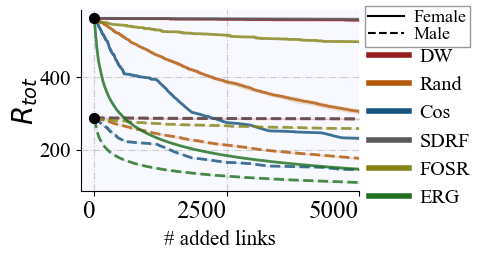

.\results\figures\evolution\google\5000\evolution_google_5000_diameter_BOTH.png


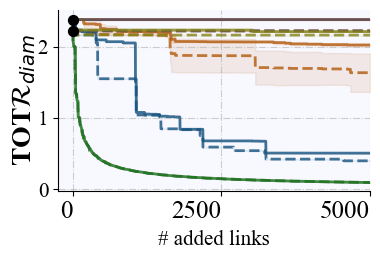

.\results\figures\evolution\google\5000\evolution_google_5000_avg_diam_BOTH.png


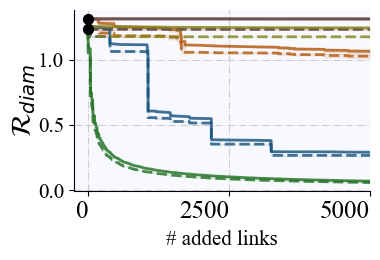

1.999429874572406
.\results\figures\evolution\google\5000\evolution_google_5000_avg_betw_BOTH.png


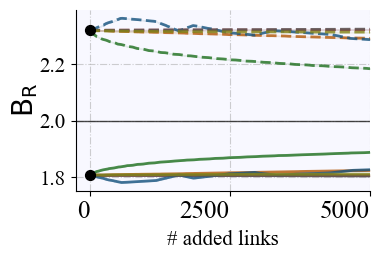

.\results\figures\evolution\google\5000\evolution_google_5000_std_betw_BOTH.png


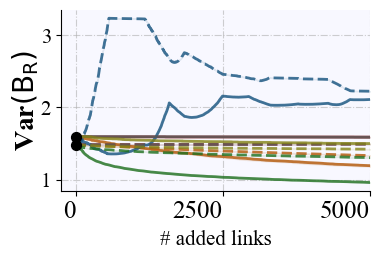

In [49]:
for metric in metrics:
    showleg = True if metric=='total_er' else False
    plot_evolution_all_g(metric, save='png', slegend=showleg)
    

1.998065764023211
.\results\figures\evolution\facebook\5000\evolution_facebook_5000_avg_betw_BOTH.png


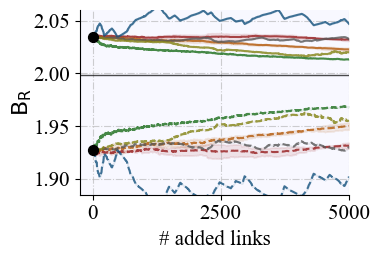

In [28]:
plot_evolution_all_g('avg_betw', save='png', slegend=False, lims=[None, (1.885, 2.06)],
                     bbox = (-0.01, 0.57))

## Evolution SGU

* 1 plot for each fairness metric (difference of the metric for male and female)
* One line for each fair metric evolution with different models
* Fair metric comprenheds both groups

In [43]:
def plot_evolution_fair(metric, save=None, slegend = True, lims=None):   
    
    colors = cmap(np.linspace(0, 1, len(group_mean_results_dict)))
    if slegend:
        fig, ax = plt.subplots(figsize=(5, 2.7))
    else:
        fig, ax = plt.subplots(figsize=(3.9, 2.7))
    
    for i, model_key in enumerate(group_mean_results_dict):
        mean_res = np.array(group_mean_results_dict[model_key][1][metric]) - np.array(group_mean_results_dict[model_key][0][metric])
        ax.plot(np.abs(mean_res), label=rename_methods[model_key], color=color_methods[model_key], alpha=0.7, linewidth=2)
        #std_res = group_std_results_dict[model_key][1][metric]+group_std_results_dict[model_key][0][metric]
        #ax.fill_between(np.arange(len(mean_res)), mean_res-std_res, mean_res+std_res, color=colors[i], alpha=0.2)
    ax.set_ylabel(fr'$\Delta$ {rename_metrics[metric]}', fontsize=16, labelpad=0, fontweight='bold')
    ax.set_xlabel("# added links", fontsize=15)#ax.set_xlabel("$|\mathcal{E}'\:\\backslash\:\mathcal{E}|$")
    #ax.set_ylabel(fr'$\Delta$ {rename_metrics[metric]}')
    
    if slegend:
        handles_method = []
        labels_method = []
        for i, model_key in enumerate(group_mean_results_dict):
            handles_method.append(plt.Line2D([], [], color=color_methods[model_key], linewidth=4))
            labels_method.append(rename_methods[model_key])
        #order = [3,1,4,6,2,0,5]
        #order = [0,1,2,4,3]
        order = np.arange(len(handles_method))
        ax.legend([handles_method[ix] for ix in order], [labels_method[ix] for ix in order], bbox_to_anchor=(1.0, .5), loc='center left',
                borderaxespad=0., handletextpad=0.5, borderpad=0.5, labelspacing=0.5, frameon=False)
        

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(alpha=0.6, linestyle='-.')
    
    ax.set_xlim(None, N_LINKS)   
    #set ticks to show 5 points between 0 and xlimit
    ax.set_xticks(np.linspace(0, N_LINKS, 3))
    #set xticks labels to be integers
    ax.set_xticklabels(np.linspace(0, N_LINKS, 3, dtype=int), fontsize=18, ha='right')
    #set fontsize of yticks
    plt.yticks(fontsize=18)

    if lims is not None:
        ax.set_ylim(lims[0])
        ax.set_ylim(lims[1])

    
    plt.tight_layout()
    
    if save is not None:
        fig_name = fig_name = 'evolution_'+DATASET+'_'+str(N_LINKS)+'_'+metric+'_FAIR.'+save
        if not osp.exists(osp.join(PATH_FIGURES, 'evolution', DATASET, str(N_LINKS))):
            os.makedirs(osp.join(PATH_FIGURES, 'evolution', DATASET, str(N_LINKS)))
        plt.savefig(osp.join(PATH_FIGURES, 'evolution', DATASET, str(N_LINKS), fig_name),
                    dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

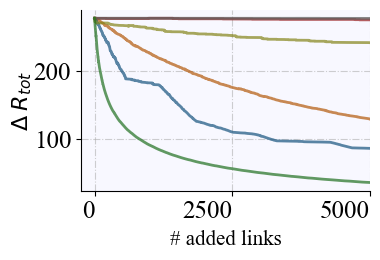

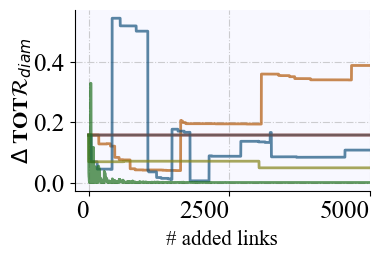

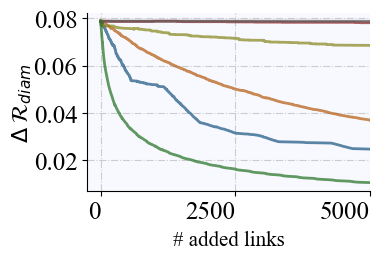

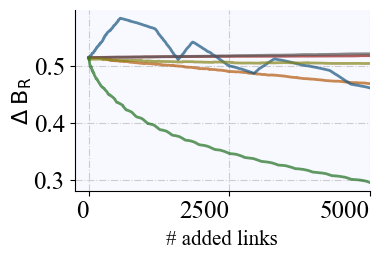

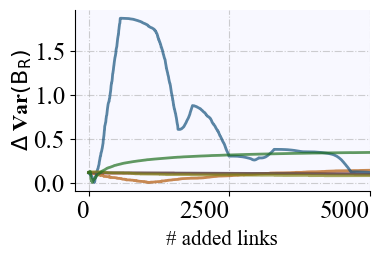

In [44]:
for metric in metrics:
    showleg = True if metric=='total_er' else False
    plot_evolution_fair(metric, save='png', slegend=False)

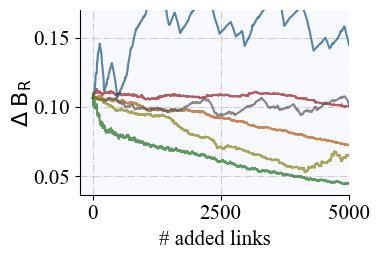

In [27]:
plot_evolution_fair('avg_betw', save='png', slegend=False, lims=[None, (None, 0.17)])

## Pareto fronts

In [14]:
dict_final_results = {}
for model_key in group_mean_results_dict:
    dict_final_results[model_key] = {}
    for group in group_mean_results_dict[model_key]:
        dict_final_results[model_key]
        for metric in group_mean_results_dict[model_key][group]:
            dict_final_results[model_key][(metric,group)] = group_mean_results_dict[model_key][group][metric][-1]


df_pareto = pd.DataFrame.from_dict(dict_final_results).T

In [15]:
from matplotlib.ticker import ScalarFormatter, StrMethodFormatter


In [50]:
def pareto_metric(metric, df, save=False, slegend='outside', lims = None, arrow=False):
    if slegend=='outside':
        fig, ax = plt.subplots(figsize=(4.52, 2.5))
    else:
        fig, ax = plt.subplots(figsize=(3.4, 2.5))
    colors = cmap(np.linspace(0, 1, len(df.index)))
    for i, model_key in enumerate(df.index):
        if model_key == 'ERP_weak':
            #marker is a star
            marker = '*'
            size = 300
            alpha=1
        else:
            marker= 'o'
            size=100
            alpha=.7
        ax.scatter(np.abs(df[metric].loc[model_key][1]-df[metric].loc[model_key][0]),
                   df[metric].loc[model_key][0]+df[metric].loc[model_key][1],
                   label=rename_methods[model_key], color=color_methods[model_key], s=size, alpha=alpha,
                   marker=marker, clip_on=False)
        
    # plot legend outside
    
    #ax.set_title(rename_metrics[metric])
    ax.set_xlabel(fr'$\Delta$ {rename_metrics[metric]}', fontsize=14, labelpad=.1)
    ax.set_ylabel(fr'$\sum${rename_metrics[metric]}$(S_i)$  $\forall i \in S$', fontsize=14, labelpad=.1)
    ax.grid(alpha=0.6, linestyle='-.')

    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    

     #custom order of labels
    handles, labels = ax.get_legend_handles_labels()
    #order = [3,1,4,6,2,0,5]
    order = np.arange(len(handles))
    #order = [1,0,2,4,3]
    if slegend=='outside':
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.0, .5), loc='center left',
                borderaxespad=0., fancybox=True, shadow=True, ncols=1,
                columnspacing=0.5, handletextpad=0.5, borderpad=0.5, labelspacing=0.5,
                facecolor='white', framealpha=1,frameon=False)
    elif slegend=='inside':
        #locate legend at top left corner
        """ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                loc=leg_loc, fancybox=True, shadow=True, ncol=2,  
                columnspacing=0.05, handletextpad=.01, borderpad=0.05, labelspacing=0.3, fontsize=13,
                bbox_to_anchor=(-0.02, 1.05))"""
        #locate in bottom right corner
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                loc='lower right', fancybox=True, shadow=True, ncol=2,  
                columnspacing=0.05, handletextpad=.1, borderpad=0.1, labelspacing=0.3, fontsize=12,
                bbox_to_anchor=(1.0, 0.0), facecolor='white', framealpha=1)


    if lims is not None:
        ax.set_xlim(lims[0])
        ax.set_ylim(lims[1])
    else:
        #get actual limits
        xleft, xright = plt.xlim()
        ybottom, yup  = plt.ylim()
        #set limits to be 10% bigger
        ax.set_xlim(xleft-(xright-xleft)*.05, None)
        ax.set_ylim(ybottom-(yup-ybottom)*.05, None)
        
        
    if metric == 'avg_betw':
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
    else:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    if arrow:
        xleft, xright = plt.xlim()
        ybottom, yup  = plt.ylim()
        arrow_start = (xright,
                       yup)  # Bottom right corner with a bit pad
        
        xpoint = xleft + (xright-xleft)/2
        ypoint = ybottom + (yup-ybottom)/2
        arrow_end = (xpoint, ypoint)  # Middle of the plot

        # Draw the arrow with a label (text along the arrow)
        plt.annotate(None,  # The text you want to display
                    xy=arrow_end,  # The position of the text (middle of the plot)
                    xytext=arrow_start,  # The position of the arrow (bottom right corner)
                    arrowprops={'arrowstyle': 'simple,head_length=2,head_width=2, tail_width=0.3',
                                'lw': 8, 'color': '#3cba54', 'alpha':.9 #3cba54,
                               },  # Arrow style and label
                    fontsize=12, color='red',  # Text style
                    ha='center', va='center',
                    )
        plt.text((arrow_start[0]+arrow_end[0])/2,
                 (arrow_start[1]+arrow_end[1])/2,
                 'Better model', 
                 fontsize=12,
                 fontweight='bold',
                 color='grey',
                 horizontalalignment='center',
                 verticalalignment='center',
                 bbox=dict(facecolor='white', alpha=.8, linewidth=0)
                )
        
    plt.tight_layout()
    if save:
        fig_name = fig_name = 'pareto_'+DATASET+'_'+str(N_LINKS)+'_'+metric+'.pdf'
        if not osp.exists(osp.join(PATH_FIGURES, 'pareto', DATASET, str(N_LINKS))):
            os.makedirs(osp.join(PATH_FIGURES, 'pareto', DATASET, str(N_LINKS)))
        plt.savefig(osp.join(PATH_FIGURES, 'pareto', DATASET, str(N_LINKS), fig_name),
                    dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

In [40]:
metrics

['total_er', 'diameter', 'avg_diam', 'avg_betw', 'std_betw']

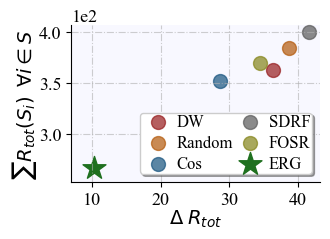

In [51]:
pareto_metric('total_er', df_pareto, save='pdf', slegend='inside')

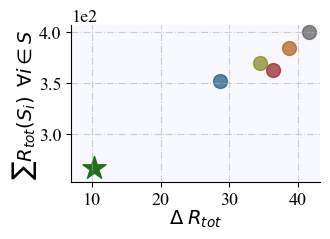

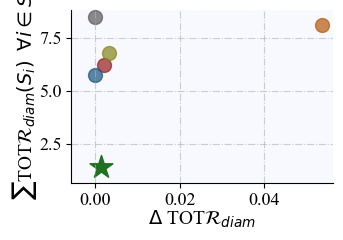

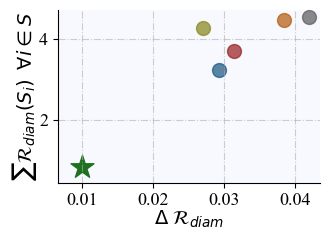

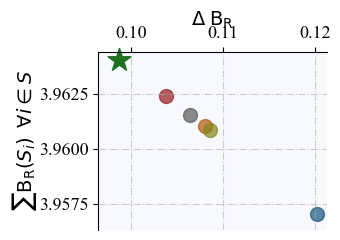

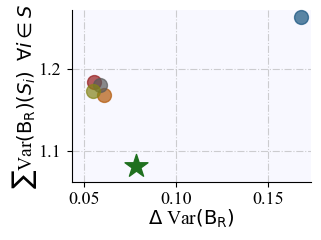

In [33]:
for metric in metrics:
    showleg = 'outside' if DATASET=='facebook' else False
    pareto_metric(metric, df_pareto, save='pdf', slegend=False)

In [ ]:
pareto_metric('total_er', df_pareto, save=False, slegend=showleg, arrow=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull

# Sample data
np.random.seed(42)
x = np.random.rand(50)
y = np.random.rand(50)

# Function to check if a point dominates another
def dominates(x1, y1, x2, y2):
    return (x1 >= x2 and y1 >= y2) and (x1 > x2 or y1 > y2)

# Identify Pareto points    
pareto_set = []
for i in range(len(x)):
    is_pareto = all(not dominates(x[j], y[j], x[i], y[i]) for j in range(len(x)))
    if is_pareto:
        pareto_set.append((x[i], y[i]))

plt.figure(figsize=(5, 3))
plt.scatter(x, y, label='Data Points', zorder=3, s=50)


# add limits of the plot to the paresoset
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
pareto_set.append((xlim[0],ylim[0]))
plt.ylim(ylim)
plt.xlim(xlim)
# add pareto sex max first dimension
pareto_set.append((xlim[0],max([t[1] for t in pareto_set])))
pareto_set.append((max([t[0] for t in pareto_set]), ylim[0]))
#pareto_set.append((0,1))
# Create a scatter plot


# Identify convex hull of Pareto set
points = np.array(pareto_set)
hull = ConvexHull(points)
plt.fill(points[hull.vertices, 0], points[hull.vertices, 1], edgecolor='black', facecolor='orange', alpha=0.3)

# Set plot properties
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Pareto Frontier')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
exitazo

##  Violinplots

**CALCULATED FROM NUMBER OF LOADED LINKS, NOT SELECTED ONES**

In [29]:

cmap = plt.get_cmap('tab10')
color_methods = {
    'original': 'black',
    'cosine_strong': cmap(0),
    'cosine_weak': cmap(4),
    'deepwalk_weak': cmap(5),
    'deepwalk_strong': cmap(3),
    'random_weak': cmap(1),
    'ERP_weak': cmap(2),
    'ERP_strong': cmap(6),
    'SDRF_weak': cmap(7),
    'FOSR_weak': cmap(8)
}

palette= {rename_methods[k]:color_methods[k] for k in color_methods}

In [30]:
ER_dict = {}
for fold in folders:
    # get model and strategy from folder name
    model = fold.split('_')[1]
    strategy = fold.split('_')[2]

    model_key = model+'_'+strategy

    loaded_ER = np.load(open(osp.join('results', fold, 'R.npy'), 'rb'))
    ER_dict[model_key] = loaded_ER

In [31]:
import utils.data_loader as loader
GW = loader.load_data(dataset = DATASET,
                      device = 'cpu')

Loaded Graph with 1034 nodes and 26749 edges - L computation mode: exact


In [32]:
ER_dict['original'] = GW.get_effective_resistance().numpy()

In [40]:
SELECTED_METHODS = ['original'] + SELECTED_METHODS

In [41]:
distances = []
keys = []
for key in ER_dict:
    #get triangular superior matrix
    dist = ER_dict[key][np.triu_indices(ER_dict[key].shape[0], k=1)]
    distances.append(dist)
    keys.append(key)

**All RW**

In [42]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", palette = "Set2", rc=custom_params)

In [43]:
df = pd.DataFrame(columns=ER_dict.keys())
for key in ER_dict:
    df[key] = ER_dict[key][np.triu_indices(ER_dict[key].shape[0], k=1)]
df = df[SELECTED_METHODS]
#pivot df to have one clumn named method, so the finals columns are total_er, method and sens
df = df.melt(var_name='method', value_name='Ruv')

In [44]:
df['method'] = df['method'].replace(rename_methods)

In [45]:
def show_violin_metric(df,metric,title=True, left_axes=True, hue=None, legend = False, save=False):
    fontsize = 18
    mypal = palette if hue is None else None
    f, ax = plt.subplots(figsize= (6,4), ncols=1, nrows=1, sharey=True, gridspec_kw={'hspace':0.0})
    sns.violinplot(data=df, y='method', x = metric, orient='h', hue=hue,  palette=mypal,
                split=True, scale='width', linewidth=1, cut=0, inner='quartile', ax=ax)
    ax.tick_params(labelsize=fontsize)
    ax.set_xlabel(f'{rename_metrics[metric]}(u)', fontsize=fontsize)
    if title:
        ax.set_ylabel(f"""{DATASET.upper()} ($B$={N_LINKS})""", fontsize=fontsize)

    if not left_axes:
        ax.set(yticklabels=[])
        ax.set(ylabel=None)
        #ax_left.tick_params(left=False)
    if hue:
        ax.legend_.remove()
    if legend:
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles, [rename_groups[int(label)] for label in labels], title=None,
                loc='lower right', fontsize=14)
    
    plt.tight_layout()

    if save:
        fig_name = fig_name = 'violin_'+DATASET+'_'+str(N_LINKS)+'_'+metric+'.pdf'
        if not osp.exists(osp.join(PATH_FIGURES, 'violin', DATASET, str(N_LINKS))):
            os.makedirs(osp.join(PATH_FIGURES, 'violin', DATASET, str(N_LINKS)))
        plt.savefig(osp.join(PATH_FIGURES, 'violin', DATASET, str(N_LINKS), fig_name),
                    dpi=300, bbox_inches='tight', pad_inches=0)

    plt.show()


def show_broken_violin_metric(df,metric,limitx,title=True,left_axes=True,PAD=0.3, hue=None, legend = False, save = False):
    mypal = palette if hue is None else None
    fontsize = 18
    f, (ax_left, ax_right) = plt.subplots(figsize= (6,4), ncols=2, nrows=1, sharey=True, gridspec_kw={'hspace':0.0})

    sns.violinplot(data=df, y='method', x = metric, orient='h', hue=hue,
                split=True, scale='width', linewidth=1, cut=0, inner='quartile', ax=ax_left, palette=mypal)
    sns.violinplot(data=df, y='method', x = metric, orient='h', hue=hue,
                split=True, scale='count', linewidth=1, cut=0, inner='quartile', ax=ax_right, palette=mypal)
    ax_left.set_xlim(right=limitx[0])   # those limits are fake
    ax_right.set_xlim(left=limitx[1])
    ax_left.axvline(limitx[0], color='grey', alpha=.5, linestyle='-.')
    if metric != 'Ruv':
        ax_left.set_xlabel(f'{rename_metrics[metric]}(u)', fontsize=fontsize)
    else:
        ax_left.set_xlabel(f'{rename_metrics[metric]}', fontsize=fontsize)
    ax_right.axvline(limitx[1], color='grey', alpha=.5, linestyle='-.')

    ax_left.tick_params(labelsize=fontsize)
    ax_right.tick_params(labelsize=fontsize)

    if title:
        ax_left.set_ylabel(f"""{DATASET.upper()} ($B$={N_LINKS})""", fontsize=fontsize)

    sns.despine(ax=ax_left, right=True)
    if not left_axes:
        ax_left.set(yticklabels=[])
        ax_left.set(ylabel=None)
        #ax_left.tick_params(left=False)

    ax_right.set(ylabel=None)
    ax_right.set(xlabel=None)
    ax_right.tick_params(left=False)
    sns.despine(ax=ax_right, left=True)

    if hue:
        ax_left.legend_.remove()
        ax_right.legend_.remove()
    if legend:
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles, [rename_groups[int(label)] for label in labels], title=None,
                loc='lower right', fontsize=14)

    plt.tight_layout(pad=PAD)



    ax = ax_right
    d = .02  # how big to make the diagonal lines in axes coordinates
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs) #bottom left of the right axes      

    ax2 = ax_left
    kwargs.update(transform=ax2.transAxes)  
    ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs) 


    if save:
        fig_name = fig_name = 'violin_'+DATASET+'_'+str(N_LINKS)+'_'+metric+'.pdf'
        if not osp.exists(osp.join(PATH_FIGURES, 'violin', DATASET, str(N_LINKS))):
            os.makedirs(osp.join(PATH_FIGURES, 'violin', DATASET, str(N_LINKS)))
        plt.savefig(osp.join(PATH_FIGURES, 'violin', DATASET, str(N_LINKS), fig_name),
                    dpi=300, bbox_inches='tight', pad_inches=0)

    plt.show()

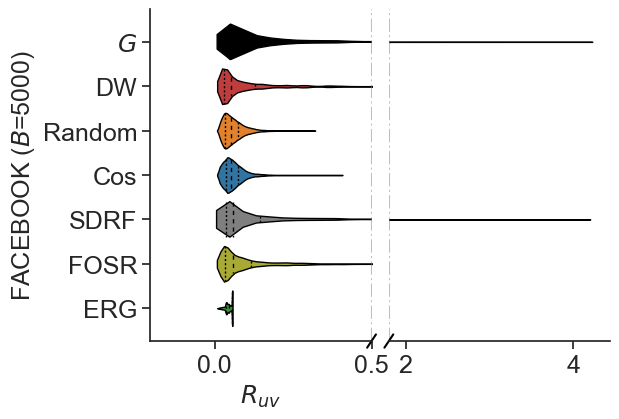

In [46]:
show_broken_violin_metric(df, 'Ruv', limitx=[0.5,1.8],left_axes=True, PAD=.0, save=True)

**Res G**

In [47]:
# create empty pandas with columns
df = pd.DataFrame(columns=ER_dict.keys())
for key in ER_dict:
    df[key] = ermet.node_total_er(torch.Tensor(ER_dict[key]))
df['sens'] = GW.sens.numpy()
df = df[SELECTED_METHODS+['sens']]
#pivot df to have one clumn named method, so the finals columns are total_er, method and sens
df = df.melt(id_vars=['sens'], var_name='method', value_name='total_er')

In [48]:
#sens to int
df['sens'] = df['sens'].astype(int)
df['method'] = df['method'].replace(rename_methods)

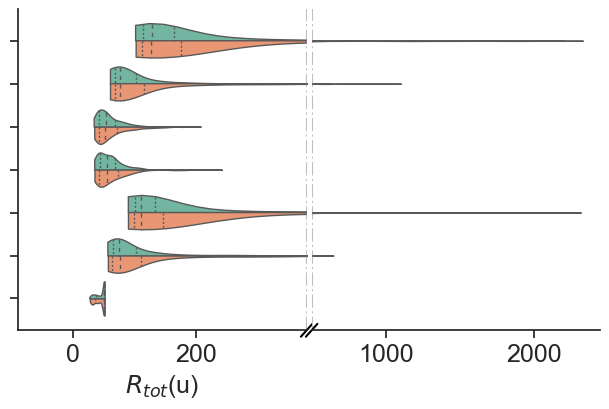

In [61]:
show_broken_violin_metric(df, 'total_er', limitx=[380,500],left_axes=False, hue='sens', legend=False, PAD=0.3, save=True)

**R diam**

In [62]:
rename_metrics['diameter']= '$\mathcal{R}_{diam}$'

In [63]:
# create empty pandas with columns
df = pd.DataFrame(columns=ER_dict.keys())
for key in ER_dict:
    df[key] = ermet.node_diam(torch.Tensor(ER_dict[key]))
df['sens'] = GW.sens.numpy()
df = df[SELECTED_METHODS+['sens']]
#pivot df to have one clumn named method, so the finals columns are total_er, method and sens
df = df.melt(id_vars=['sens'], var_name='method', value_name='diameter')


In [64]:
df['sens'] = df['sens'].astype(int)
df['method'] = df['method'].replace(rename_methods)

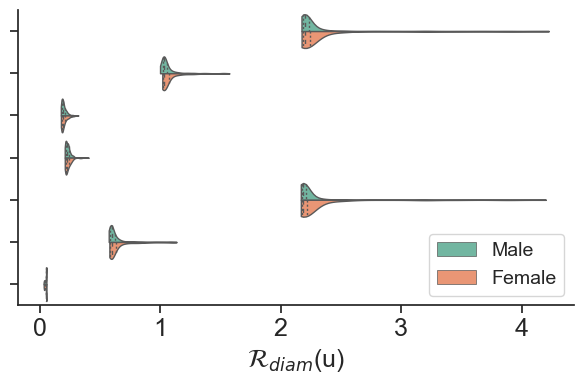

In [65]:
show_violin_metric(df, 'diameter', title=True, left_axes=False, hue='sens', legend=True, save=True)

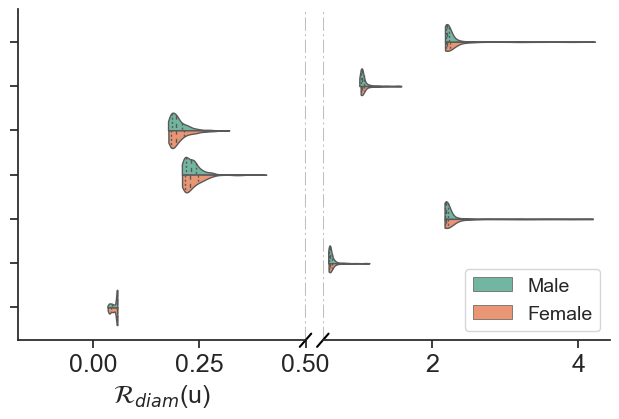

In [78]:
show_broken_violin_metric(df, 'diameter', limitx=[.5,.5],left_axes=False, legend=True, hue='sens', PAD=0,save=True)

**R betweenness**

In [79]:
# create empty pandas with columns
df = pd.DataFrame(columns=ER_dict.keys())
for key in ER_dict:
    df[key] = ermet.node_betwenness(torch.Tensor(ER_dict[key]), ~GW.edge_mask)
df['sens'] = GW.sens.numpy()

df = df[SELECTED_METHODS+['sens']]
#pivot df to have one clumn named method, so the finals columns are total_er, method and sens
df = df.melt(id_vars=['sens'], var_name='method', value_name='betw')

In [80]:
df['sens'] = df['sens'].astype(int)
df['method'] = df['method'].replace(rename_methods)

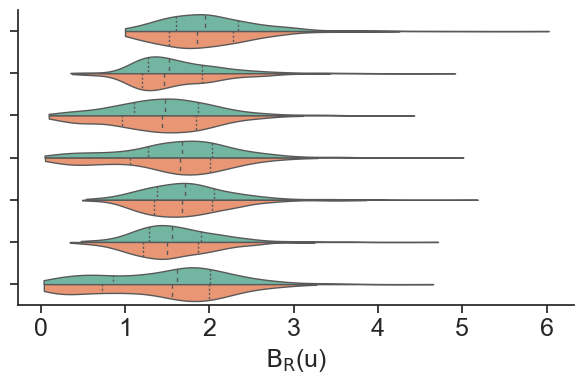

In [83]:
show_violin_metric(df, 'betw',left_axes=False, hue='sens', legend=False, save=True)

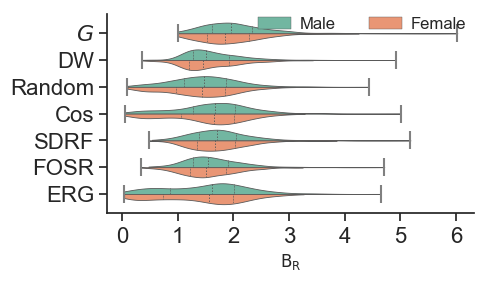

In [82]:
plt.figure(figsize=(5, 3))
sns.violinplot(data=df, y='method', x = 'betw', hue='sens', orient='h', inner='quart', split=True, cut=0, linewidth=.6,
               density_norm='area')
plt.ylabel('')
plt.xlabel(rename_metrics['avg_betw'])
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

for i,m in enumerate(SELECTED_METHODS):
    #plt.scatter(df[(df['method']==rename_methods[m]) & (df['sens']==0)]['betw'].mean(),i, marker='|', s=200, color='green')
    #plt.scatter(df[(df['method']==rename_methods[m]) & (df['sens']==1)]['betw'].mean(),i, marker='|', s=200, color='orange')
    plt.scatter(df[(df['method']==rename_methods[m])]['betw'].max(),i, marker='|', s=170, color='grey')
    plt.scatter(df[(df['method']==rename_methods[m])]['betw'].min(),i, marker='|', s=170, color='grey')
    #plt.axvline(2-2/N_NODES, color='black', linestyle='--', linewidth=1)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, [rename_groups[int(label)] for label in labels], title=None,
           loc='upper left', fontsize=12, ncols=2, bbox_to_anchor=(.37, 1.06), frameon=False, handletextpad=.5)


fig_name = fig_name = 'violin_'+DATASET+'_'+str(N_LINKS)+'_BETW.pdf'
if not osp.exists(osp.join(PATH_FIGURES, 'violin', DATASET, str(N_LINKS))):
    os.makedirs(osp.join(PATH_FIGURES, 'violin', DATASET, str(N_LINKS)))
plt.savefig(osp.join(PATH_FIGURES, 'violin', DATASET, str(N_LINKS), fig_name),
            dpi=300, bbox_inches='tight', pad_inches=0)

#plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

## Tables
* Improvement on all metrics for one group
  * Models x metrics = init - final
* Improvement of fairness metrics
  * Models - metrics = (init0-init1) - (final0-final1)

Improvement for one group

In [ ]:
GROUP = 0

In [ ]:
#make a pandas where columns are the metrics, rows are the methods and values are the initial metric minus the final metric
metrics = list(group_mean_results_dict[next(iter(group_mean_results_dict))][0].keys())
df = pd.DataFrame(columns=metrics)
for model_key in group_mean_results_dict:
    df.loc[model_key] = [group_mean_results_dict[model_key][GROUP][metric][-1]for metric in metrics]

for metric in metrics:
    df.loc['original', metric] = group_mean_results_dict['ERP_weak'][GROUP][metric][0]

In [ ]:
models = ['original',
        'deepwalk_weak', 'cosine_weak', 'SDRF_weak', 'ERP_strong', 'random_weak', 
        'deepwalk_strong', 'cosine_strong', 'ERP_weak']

models = ['original']+SELECTED_METHODS
models

In [ ]:
df = df.loc[models]

In [ ]:
df.rename(index=rename_methods, inplace=True)
df.rename(columns=rename_metrics, inplace=True)

In [ ]:
print(df.to_latex(float_format="%.4f"))

In [ ]:
print(df[['$R_{tot}$',
       '$\mathcal{R}_{diam}$',
       '$\mathsf{B_R}$']].abs().to_latex(float_format="%.3f"))

Improvement for the other group

In [ ]:
GROUP = 1

In [ ]:
#make a pandas where columns are the metrics, rows are the methods and values are the initial metric minus the final metric
metrics = list(group_mean_results_dict[next(iter(group_mean_results_dict))][0].keys())
df = pd.DataFrame(columns=metrics)
for model_key in group_mean_results_dict:
    df.loc[model_key] = [group_mean_results_dict[model_key][GROUP][metric][-1] for metric in metrics]

In [ ]:
for metric in metrics:
    df.loc['original', metric] = group_mean_results_dict['ERP_weak'][GROUP][metric][0]

In [ ]:
df = df.loc[models]

In [ ]:
df.rename(index=rename_methods, inplace=True)
df.rename(columns=rename_metrics, inplace=True)

In [ ]:
print(df[['$R_{tot}$',
       '$\mathcal{R}_{diam}$',
       '$\mathsf{B_R}$']].abs().to_latex(float_format="%.3f"))

**Difference for both groups**

In [ ]:
group_mean_results_dict.keys()

In [ ]:
#make a pandas where columns are the metrics, rows are the methods and values are the difference between the final metric between the two groups
metrics = list(group_mean_results_dict[next(iter(group_mean_results_dict))][0].keys())
df = pd.DataFrame(columns=metrics)
for model_key in group_mean_results_dict:
    df.loc[model_key] = [group_mean_results_dict[model_key][1][metric][-1]-group_mean_results_dict[model_key][0][metric][-1] for metric in metrics]

In [ ]:
for metric in metrics:
    df.loc['original', metric] = group_mean_results_dict['ERP_weak'][1][metric][0]-group_mean_results_dict['ERP_weak'][0][metric][0]

In [ ]:
df.index

In [ ]:
models

In [ ]:
df = df.loc[models]
df.rename(index=rename_methods, inplace=True)
df.rename(columns={k: fr'$\delta${v}' for k,v in rename_metrics.items()}, inplace=True)

In [ ]:
df.abs()

In [ ]:
print(df.abs().to_latex(float_format="%.4f"))

In [ ]:
print(df[['$\delta$$R_{tot}$',
       '$\delta$$\mathcal{R}_{diam}$',
       '$\delta$$\mathsf{B_R}$']].abs().to_latex(float_format="%.3f"))